---
## Data Driven Modeling WS24/25
### Milestone 5 - Final Results
### by Ole Berg, Kristan Böttjer and Lennard Feuerbach
---

### Imports

In [26]:
import numpy as np
import pandas as pd

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import cdist

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score

from fcmeans import FCM

import plotly.express as px

import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable

### Loading the data preperation notebook

76.67% of rows have industries that are not relevant


C:\Users\lenna\AppData\Local\Temp\ipykernel_1128\628047844.py:6: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



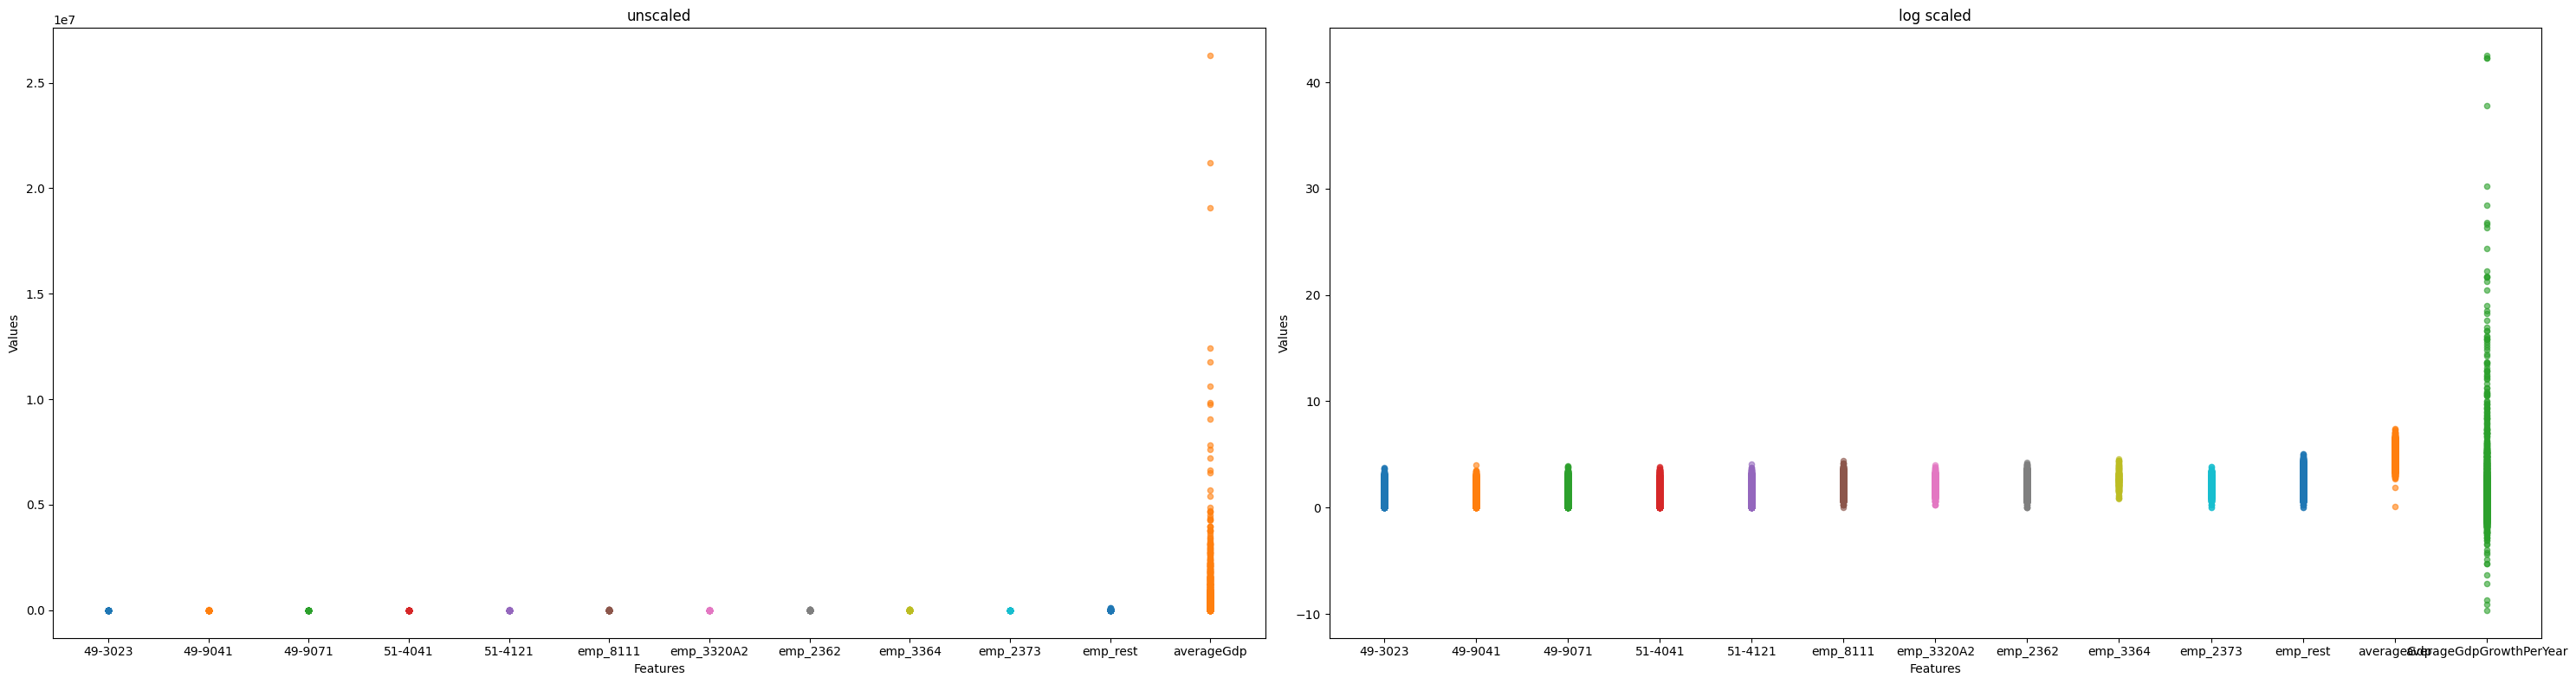

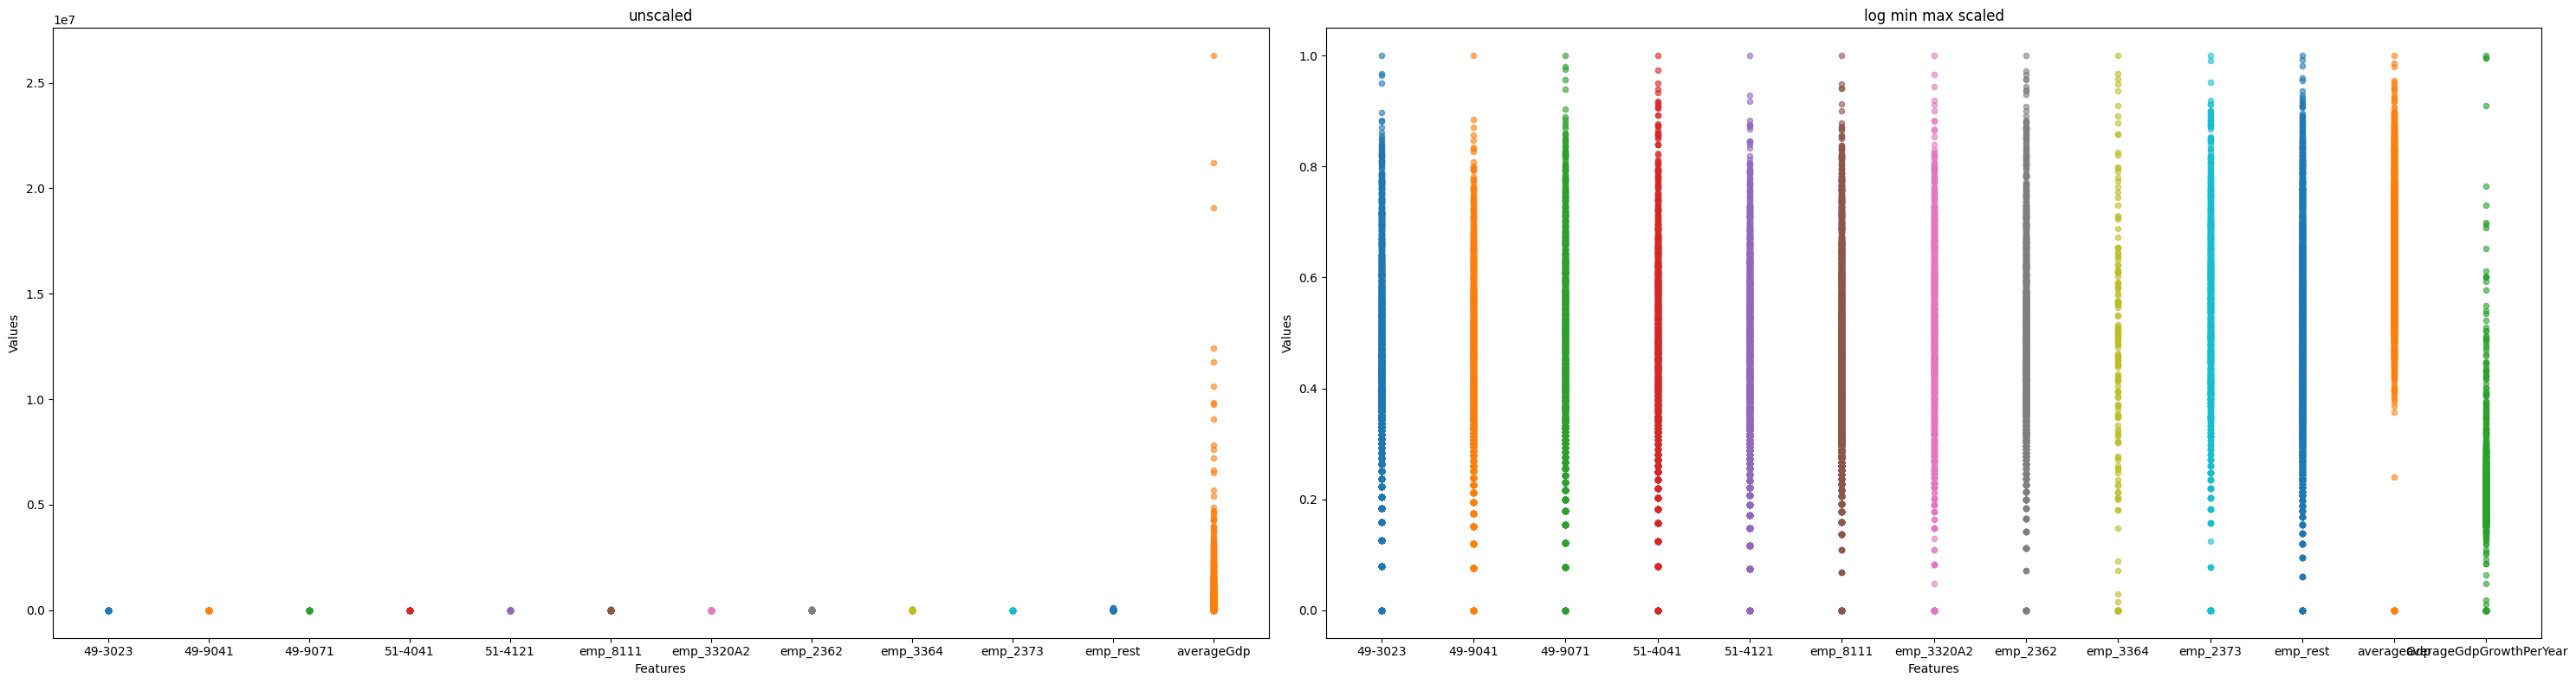

In [27]:
%run milestone_3_data_preperation_combined.ipynb

### Parameters

In [28]:
dimensions = 2
min_n_clusters = 5
max_n_clusters = 20
seed = 42

# Params which are not really necessary anymore, since grid search is used
n_opt_clusters = 12 
min_samples = 20
eps = 5

### Helper functions

#### Dimension Reduction

In [29]:
def dim_reduction(df, dimensions):    
    if dimensions == 2:
        # Using the t-SNE algorithm to reduce the dimensionality of the data to 2D
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(df)

        # Adding the t-SNE results to the master dataframe
        master_df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])

    elif dimensions == 3:
        # Using the t-SNE algorithm to reduce the dimensionality of the data to 3D
        tsne = TSNE(n_components=3, random_state=42)
        tsne_results = tsne.fit_transform(df)

        # Adding the t-SNE results to the master dataframe
        master_df_tsne = pd.DataFrame(tsne_results, columns=['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three'])

    return master_df_tsne

#### Apply Clustering

In [30]:
def apply_clustering(df, model):
    df_copy = df.copy()
    clusters = model.fit_predict(df_copy)
    df_copy['Cluster'] = clusters.astype(str)

    return df_copy

#### Visualization

In [31]:
def visualize_clusters(df, dims, name):
    df_wo_cluster = df.drop(columns=['Cluster'])
    df_reduction = dim_reduction(df_wo_cluster, dims)

    columns = df_reduction.columns
    clusters = df['Cluster']

    if dims == 2:
        fig = px.scatter(
            df_reduction,
            x=columns[0],
            y=columns[1],
            color=clusters,
            title=f"2D {name} clustering with {len(set(clusters))} clusters",
        )
        
        fig.show()

    elif dims == 3:
        
        fig = px.scatter_3d(
            df_reduction,
            x=columns[0],
            y=columns[1],
            z=columns[2],
            color=clusters,
            title=f"3D {name} clustering with {len(set(clusters))} clusters",
        )
        # Update marker size and layout
        fig.update_traces(marker=dict(size=3))
        fig.update_layout(
            scene=dict(
                xaxis_title=columns[0],
                yaxis_title=columns[1],
                zaxis_title=columns[2]
            ),
            height=700,
            width=900
        )

        fig.show()

#### Grid-Search

In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
import pandas as pd
import numpy as np

def rank_models(results):
    """
    Rank models based on Silhouette and Davies-Bouldin scores, mean ranks,
    silhouette per point standard deviation, and number of outliers.

    Parameters:
    - results (list of dict): A list containing parameters and individual scores for models.

    Returns:
    - DataFrame: Results with ranks and mean ranks.
    """
    results_df = pd.DataFrame(results)

    # Calculate ranks for individual metrics
    results_df['silhouette_rank'] = results_df['silhouette_score'].rank(ascending=False, method='min')
    results_df['davies_bouldin_rank'] = results_df['davies_bouldin_score'].rank(ascending=True, method='min')
    results_df['silhouette_std_rank'] = results_df['silhouette_std'].rank(ascending=True, method='min')  # Lower is better
    results_df['silhouette_per_point_min_rank'] = results_df['silhouette_per_point_min'].rank(ascending=False, method='min') # Higher is better
    results_df['outlier_rank'] = results_df['num_outliers'].rank(ascending=True, method='min')  # Fewer outliers preferred
    results_df['largest_cluster_ratio_rank'] = results_df['largest_cluster_ratio'].rank(ascending=True, method='min')

    # Calculate mean and std of ranks
    rank_columns = [
        'silhouette_rank',
        'davies_bouldin_rank',
        'silhouette_std_rank',
        'silhouette_per_point_min_rank',
        'outlier_rank',
        'largest_cluster_ratio_rank'
    ]
    results_df['mean_rank'] = results_df[rank_columns].mean(axis=1)
    results_df['std_rank'] = results_df[rank_columns].std(axis=1)

    # Create ranks from mean and std of ranks
    results_df['mean_rank_order'] = results_df['mean_rank'].rank(ascending=True, method='min')  # Lower mean is better
    results_df['std_rank_order'] = results_df['std_rank'].rank(ascending=True, method='min')  # Lower std is better

    # Optionally, combine mean and std ranks to create a final composite rank
    results_df['final_composite_rank'] = (results_df['mean_rank_order'] + results_df['std_rank_order']).rank(ascending=True, method='min')
    return results_df


def grid_search(X, method, param_grid):
    """
    Perform a grid search to find the best clustering model.

    Parameters:
    - X (DataFrame): The dataset.
    - method (object): Clustering method class (e.g., KMeans, DBSCAN, FCM).
    - param_grid (dict): Dictionary of parameters to try, where keys are
        parameter names and values are lists of values to iterate over.

    Returns:
    - best_model: The clustering model with the best mean rank.
    - best_params: The parameters of the best model.
    - results_df (DataFrame): DataFrame containing the results of the search.
    """
    import itertools
    from sklearn.exceptions import NotFittedError

    param_names = list(param_grid.keys())
    param_combinations = list(itertools.product(*param_grid.values()))

    results = []

    for param_combination in param_combinations:
        params = dict(zip(param_names, param_combination))
        if issubclass(method, DBSCAN) and params.get('metric') == 'mahalanobis':

            cov_matrix = np.cov(X.to_numpy(), rowvar=False)
            # Add small regularization to ensure invertibility
            cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
            params['metric_params'] = {'V': cov_matrix}
        model = method(**params)
        try:
            if isinstance(model, FCM):
                model.fit(X.to_numpy())
                # Membership probabilities
                memberships = model.u
                # Hard labels based on maximum membership probability
                labels = np.argmax(memberships, axis=1)
            else:
                labels = model.fit_predict(X)

            # Compute scores if clustering is valid
            if len(set(labels)) > 1:
                unique_labels, label_counts = np.unique(labels, return_counts=True)
                valid_counts = label_counts[unique_labels != -1]
                largest_cluster_size = np.max(valid_counts) if len(valid_counts) > 0 else 0
                largest_cluster_ratio = largest_cluster_size / len(X)
                ## hard criteria
                if largest_cluster_ratio > 0.5:
                    continue
                silhouette = silhouette_score(X, labels)
                silhouette_per_point = silhouette_samples(X, labels)
                silhouette_std = np.std(silhouette_per_point)
                davies_bouldin = davies_bouldin_score(X, labels)
                num_outliers = sum(1 for label in labels if label == -1)
            else:
                continue

            results.append({
                **params,
                'silhouette_score': silhouette,
                'silhouette_std': silhouette_std,
                'silhouette_per_point_min': np.min(silhouette_per_point),
                'davies_bouldin_score': davies_bouldin,
                'num_outliers': num_outliers,
                'largest_cluster_ratio': largest_cluster_ratio
            })
        except NotFittedError:
            # Handle cases where model fails to fit
            results.append({
                **params,
                'silhouette_score': -1,
                'silhouette_std': np.inf,
                'silhouette_per_point_min': -1,
                'davies_bouldin_score': np.inf,
                'num_outliers': len(X),
                'largest_cluster_ratio': 0
            })

    results_df = rank_models(results)
    results_df = results_df.sort_values('final_composite_rank')
    best_row = results_df.loc[results_df['final_composite_rank'].idxmin()]
    best_params = best_row[param_names].to_dict()
    return best_params, results_df


### Clustering

#### Calculating the best amount of clusters by using KMeans

In [33]:
k_means_params_dict = {
    'n_clusters': range(min_n_clusters, max_n_clusters),
    'n_init': [20],
    'random_state': [seed],
}

best_params_kmeans, kmeans_result_df = grid_search(master_df_scaled, KMeans, k_means_params_dict)

<Figure size 1500x600 with 0 Axes>

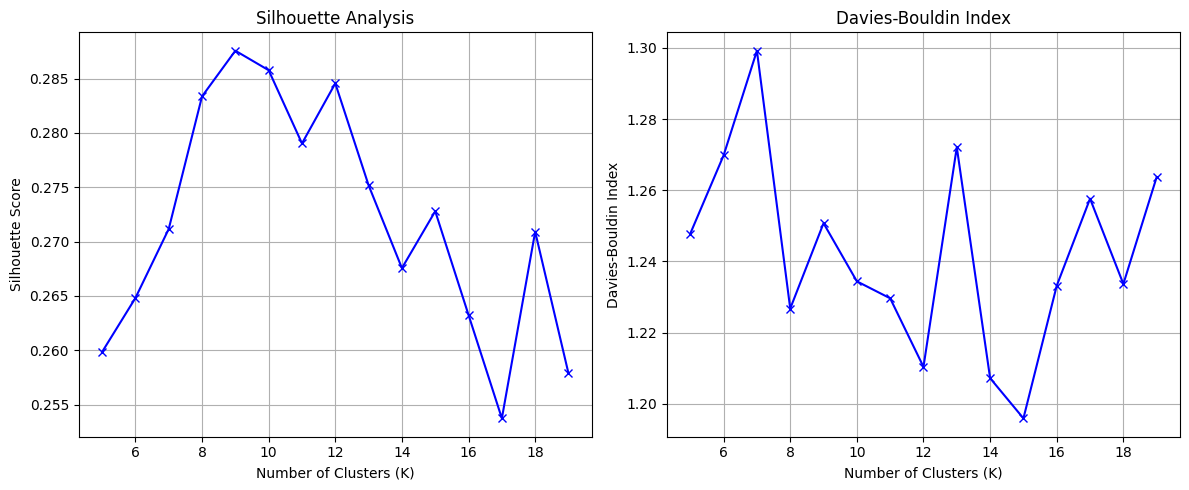

{'n_clusters': 12.0, 'n_init': 20.0, 'random_state': 42.0}

In [34]:
# Plot distortions
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot silhouette scores
results_sorted_by_clusters = kmeans_result_df.sort_values('n_clusters')

# Silhouette Analysis
axes[0].plot(results_sorted_by_clusters['n_clusters'], results_sorted_by_clusters['silhouette_score'], 'bx-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Analysis')
axes[0].grid(True)

# Davies-Bouldin Index
axes[1].plot(results_sorted_by_clusters['n_clusters'], results_sorted_by_clusters['davies_bouldin_score'], 'bx-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True)
plt.tight_layout()
plt.show()

display(best_params_kmeans)

#### k-means

In [35]:
#df_kmeans = visualize_clusters(KMeans(n_clusters=int(best_params_kmeans['n_clusters']), n_init=10, random_state=42), master_df_scaled, dimensions, "KMeans")

df_kmeans = apply_clustering(master_df_scaled, KMeans(n_clusters=int(best_params_kmeans['n_clusters']), n_init=10, random_state=42))
visualize_clusters(df_kmeans, dimensions, "KMeans")

#### DBSCAN

In [36]:
dbscan_params_dict = {
    'eps': np.arange(1, 7, 0.2),
    'min_samples':range(3,25, 2),
    'metric': ['euclidean', 'mahalanobis']
}

best_params_dbscan, dbscan_result_df = grid_search(master_df_scaled, DBSCAN, dbscan_params_dict)

In [37]:
if best_params_dbscan['metric'] == 'mahalanobis':
    cov_matrix = np.cov(master_df_scaled.to_numpy(), rowvar=False)
    # Add small regularization to ensure invertibility
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
    best_params_dbscan['metric_params'] = {'V': cov_matrix}

df_dbs = apply_clustering(master_df_scaled, DBSCAN(**best_params_dbscan))
visualize_clusters(df_dbs, dimensions, "DBSCAN")

#### Hierarchical Clustering

In [38]:
agglo_params_dict = {
    'n_clusters':range(min_n_clusters, max_n_clusters),
}

bet_params_agglo, agglo_result_df = grid_search(master_df_scaled, AgglomerativeClustering, agglo_params_dict)

In [39]:
df_hc = apply_clustering(master_df_scaled, AgglomerativeClustering(n_clusters = int(bet_params_agglo['n_clusters'])))
visualize_clusters(df_hc, dimensions, "Agglomerative Clustering")

### Cluster Analysis

In [40]:
def get_best_cluster(df, amount, method):
    if method == "mean": cluster_df = df.groupby('Cluster').mean()
    if method == "median": cluster_df = df.groupby('Cluster').median()
    
    cluster_df_rank = cluster_df.rank(ascending=False)

    # Sort the cluster_df_rank by the mean value over all columns
    cluster_df_rank["overall_avg"] = cluster_df_rank.mean(axis=1).round(2)
    cluster_df_rank = cluster_df_rank.sort_values("overall_avg")
    #display(cluster_df_rank)

    best_clusters = cluster_df_rank.head(amount)

    return best_clusters

In [41]:
def visualize_clusters_on_map(df, clusters, name):
    
    state_shape = pd.read_pickle("../data/processed/plot_state_shape.pickle")
    county_shape = pd.read_pickle("../data/processed/plot_county_shape.pickle")

    df_wo_index = df.reset_index(inplace=False)

    county_shape_with_fips = county_shape.merge(df_wo_index, on="FIPS", how="left")

    county_shape_with_fips_filtered = county_shape_with_fips[county_shape_with_fips["Cluster"].isin(clusters)].copy()

    color_palette = dict(zip(county_shape_with_fips_filtered['Cluster'].unique(), sns.color_palette("magma", county_shape_with_fips_filtered['Cluster'].nunique())))
    if '-1' in color_palette.keys():
        color_palette['-1'] = (0, 0, 0, 0)

    county_shape_with_fips_filtered['color'] = county_shape_with_fips_filtered['Cluster'].apply(lambda x: color_palette[x])

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 7)) 

    county_shape_with_fips_filtered.plot(facecolor=county_shape_with_fips_filtered['color'], linewidth=0.8, edgecolor='black', ax=ax)

    county_shape_with_fips_filtered.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)
    state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5) 

    # Create legend elements
    sorted_color_palette = sorted(color_palette.items(), key=lambda x: x[0])
    legend_elements = [Patch(facecolor=color, label=str(code)) for code, color in sorted_color_palette] 
    ax.legend(handles=legend_elements, title='Cluster ID', loc='lower right') 


    plt.title(f"Cluster Assignment to Counties, based on {name}")
    plt.axis('off')
    plt.show() 

In [42]:
def heatmap_for_cluster(df, amount, name, calc = "mean"):
    best_clusters = get_best_cluster(df, amount, calc).index

    # Filter the df by the best clusters
    df_best_clusters = df[df["Cluster"].isin(best_clusters)]

    # Drop Cluster column
    df_best_clusters = df_best_clusters.drop(columns=["Cluster"])

    # Calculate the mean value per row and add as a new column
    value_column = "overall"
    df_best_clusters[value_column] = df_best_clusters.mean(axis=1)
    
    # Load state and county shape data
    state_shape = pd.read_pickle("../data/processed/plot_state_shape.pickle")
    county_shape = pd.read_pickle("../data/processed/plot_county_shape.pickle")

    # Merge the DataFrame with the county shape data on FIPS codes
    df_wo_index = df_best_clusters.reset_index(inplace=False)
    county_shape_with_values = county_shape.merge(df_wo_index, on="FIPS", how="left")

    # Filter out rows with NaN values in the value_column
    county_shape_with_values = county_shape_with_values[county_shape_with_values[value_column].notna()]

    norm = Normalize(vmin=county_shape_with_values[value_column].min(), 
                     vmax=county_shape_with_values[value_column].max())
    county_shape_with_values['color'] = county_shape_with_values[value_column].apply(lambda x: plt.cm.Reds(norm(x)))

    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot counties with color based on the value column
    county_shape_with_values.plot(facecolor=county_shape_with_values['color'], 
                                  linewidth=0.8, edgecolor='black', ax=ax)

    # Plot state boundaries
    state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

    # Add a colorbar to show the range of values
    sm = ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
    cbar.set_label(value_column)

    # Set title and turn off axis
    plt.title(f"Heatmap for the best {amount} Cluster(s), based on {name}")
    plt.axis('off')
    plt.show()

In [43]:
def get_top_pop_counties():
    # Load extenral county data
    cc = pd.read_csv("../data/external/CountyCharacteristics_2023.csv", encoding="ISO-8859-1")

    # Select newest data
    cc = cc[cc['YEAR'] == 5]

    # Format and sort by population
    cc['FIPS'] = cc['STATE'].apply(lambda x: '{0:0>2}'.format(x)) + cc['COUNTY'].apply(lambda x: '{0:0>3}'.format(x))
    cc = cc[['FIPS', 'POPESTIMATE']]
    cc.sort_values(by=['POPESTIMATE'], ascending=False, inplace=True)
    return cc

In [44]:
def visualise_top_pop_counties(n):
    # Load shape data
    state_shape = pd.read_pickle("../data/processed/plot_state_shape.pickle")
    county_shape = pd.read_pickle("../data/processed/plot_county_shape.pickle")

    # Get list of top counties by population with length of number of counties in top cluster
    top_pop_counties = get_top_pop_counties()
    county_shape_with_fips = county_shape.merge(top_pop_counties, on="FIPS", how="inner")
    county_shape_with_fips.sort_values(by=['POPESTIMATE'], ascending=False, inplace=True)
    county_shape_with_fips = county_shape_with_fips.head(n)


    # Plotting
    fig, ax = plt.subplots(figsize=(15, 7))

    county_shape_with_fips.plot(facecolor=sns.color_palette("magma")[3], linewidth=0.8, edgecolor='black', ax=ax)

    county_shape_with_fips.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)
    state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)


    plt.title(f"Top {n} Counties Based on Population")
    plt.axis('off')
    plt.show()

In [45]:
def visualise_counties_not_in_top_pop_counties(top_cluster_counties):
    # Load shape data
    state_shape = pd.read_pickle("../data/processed/plot_state_shape.pickle")
    county_shape = pd.read_pickle("../data/processed/plot_county_shape.pickle")

    # Get list of top counties by population with length of number of counties in top cluster
    top_pop_counties = get_top_pop_counties()
    top_pop_counties = top_pop_counties.head(n=len(top_cluster_counties))

    # Keep counties in top cluster and remove those in top counties by population
    county_shape = county_shape[county_shape['FIPS'].isin(top_cluster_counties)]
    county_shape = county_shape[~county_shape['FIPS'].isin(top_pop_counties['FIPS'])]

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 7))

    county_shape.plot(facecolor=sns.color_palette("magma")[3], linewidth=0.8, edgecolor='black', ax=ax)

    county_shape.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)
    state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)


    plt.title(f"The {len(county_shape)} Counties From the Top Cluster Not in the Top {len(top_cluster_counties)} Counties by Population")
    plt.axis('off')
    plt.show()

In [46]:
def visualise_both(top_cluster_counties):
    amount = len(top_cluster_counties)

    # Load shape data
    state_shape = pd.read_pickle("../data/processed/plot_state_shape.pickle")
    county_shape = pd.read_pickle("../data/processed/plot_county_shape.pickle")

    # Get list of top counties by population with length of number of counties in top cluster
    top_pop_counties = get_top_pop_counties()
    top_pop_counties = top_pop_counties.head(amount)

    # Filter for counties in top cluster
    county_shape = county_shape[county_shape['FIPS'].isin(top_cluster_counties)]

    # Add distinct color to county_shape
    county_shape['in_top_pop'] = pd.Series('false', index=county_shape.index).mask(county_shape['FIPS'].isin(top_pop_counties['FIPS']), 'true')
    color_palette = {'true': sns.color_palette("magma")[3], 'false': sns.color_palette("magma")[1]}
    county_shape['color'] = county_shape['in_top_pop'].apply(lambda x: color_palette[x])

    #Plotting
    _, ax = plt.subplots(figsize=(15, 7))

    county_shape.plot(facecolor=county_shape['color'], linewidth=0.8, edgecolor='black', ax=ax)

    county_shape.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)
    state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    legend_elements = [Patch(facecolor=color, label=str(code)) for code, color in color_palette.items()]
    legend = ax.legend(handles=legend_elements, title=f'Also in Top {amount} Counties by Population', loc='lower left')
    legend.get_frame().set_facecolor('white')
    plt.title(f"The {amount} Counties From the Top Cluster With Distinct Color for Counties Also in the Top {amount} Counties by Population")
    plt.axis('off')
    plt.show()
    

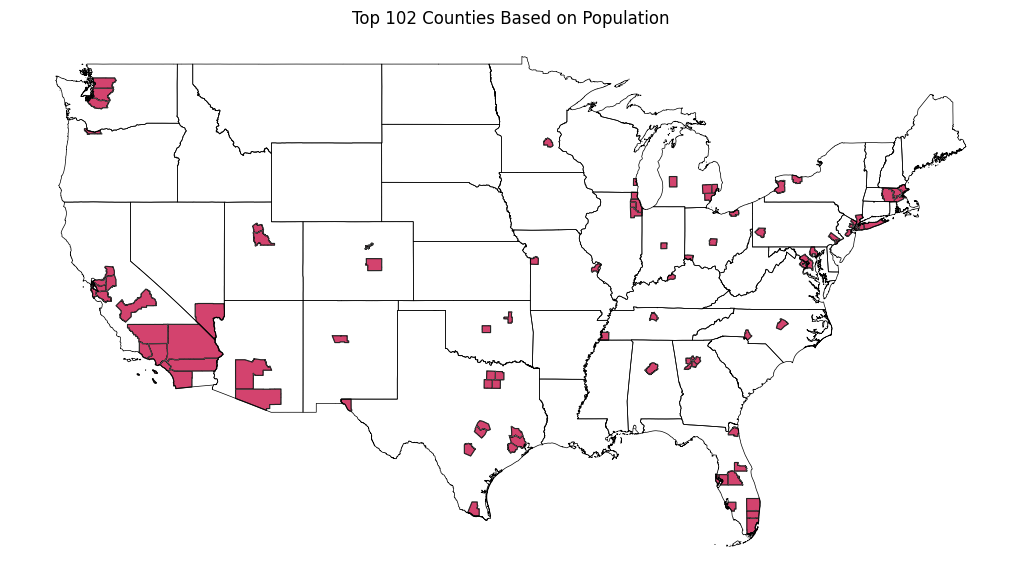

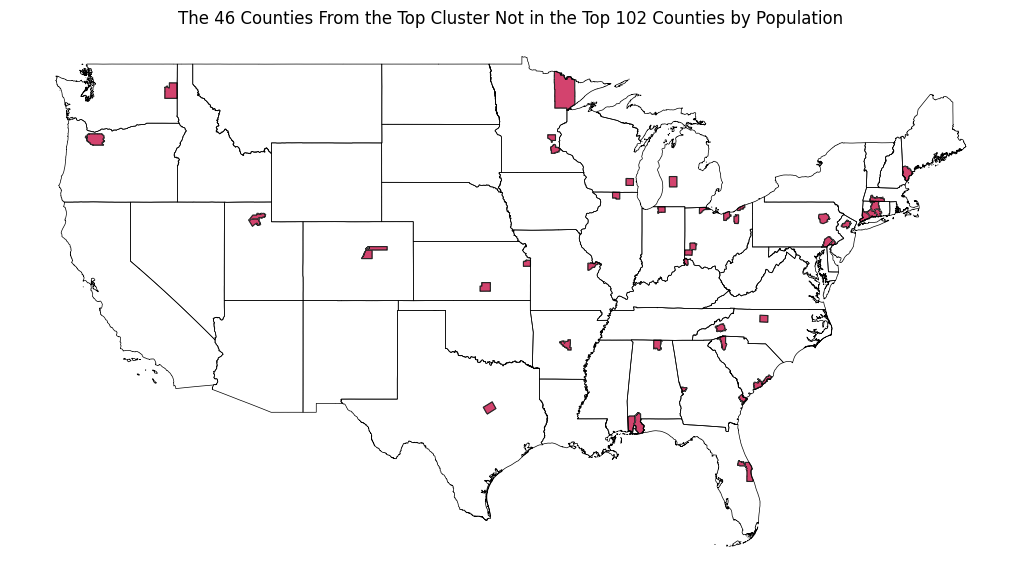

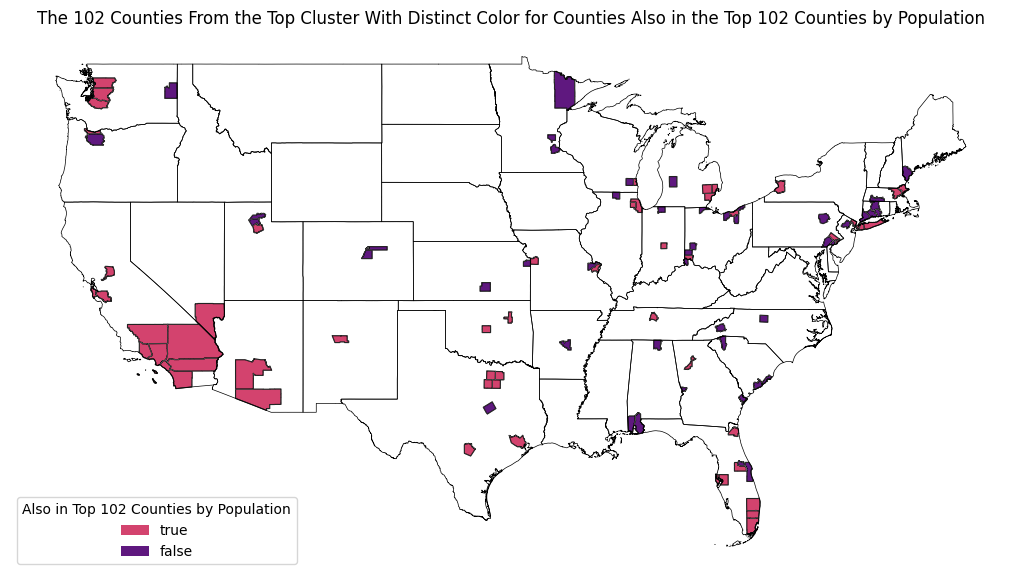

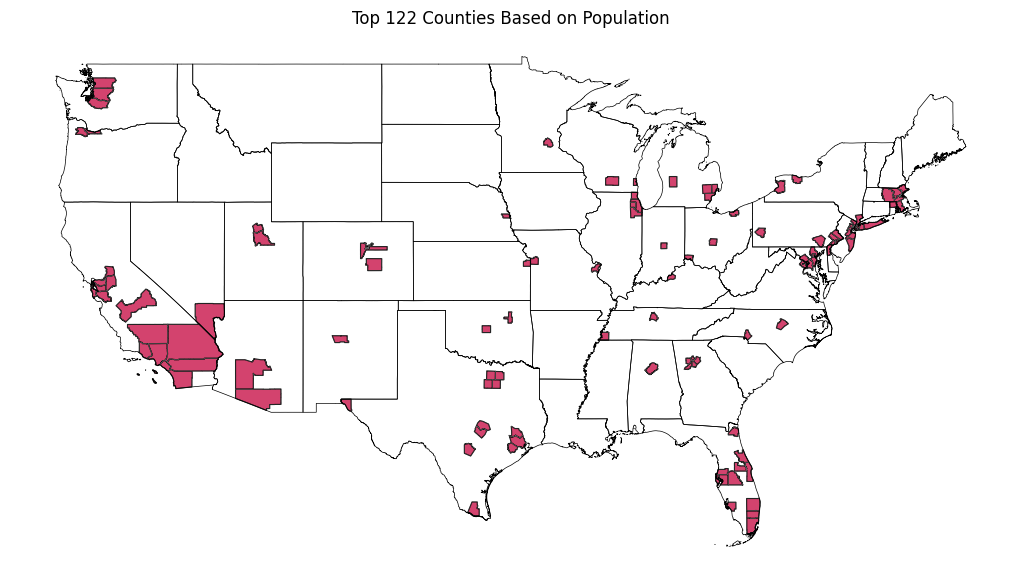

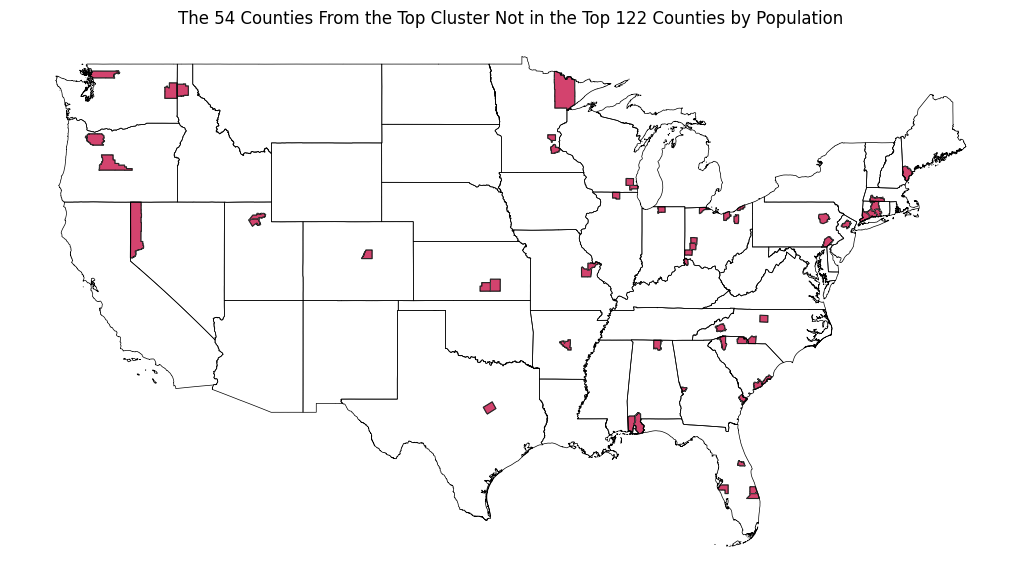

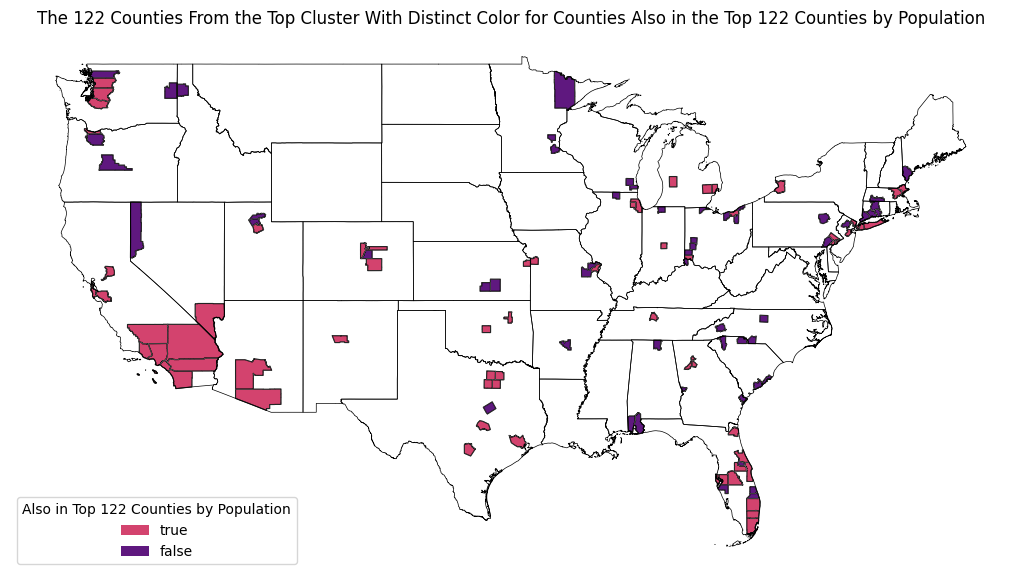

In [47]:
def vizualize_top_clusters_w_pop(df, amount, name, calc="mean"):
    best_clusters = get_best_cluster(df, amount, calc)
    best_clusters_index = best_clusters.index

    #visualize_clusters_on_map(df, best_clusters_index, name)

    top_cluster = best_clusters.head(1)
    top_cluster_id = top_cluster.index[0]

    df = df[df['Cluster'] == top_cluster_id]
    number_of_counties_in_top_cluster = len(df.index)

    visualise_top_pop_counties(number_of_counties_in_top_cluster)
    visualise_counties_not_in_top_pop_counties(df.index.tolist())
    visualise_both(df.index.tolist())

vizualize_top_clusters_w_pop(df_kmeans, 1, "KMeans")
vizualize_top_clusters_w_pop(df_hc, 1, "Hierarchical Clustering")

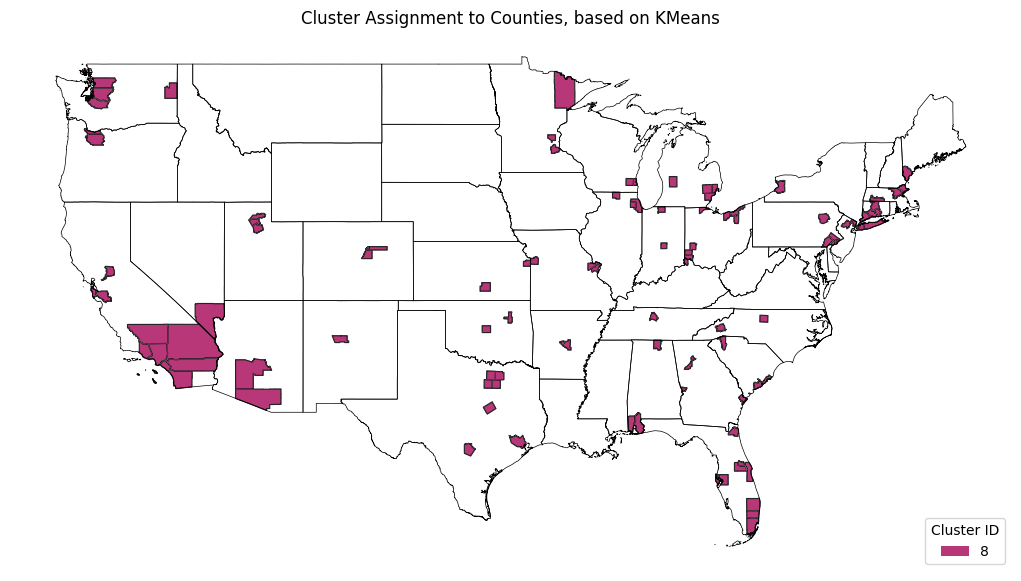

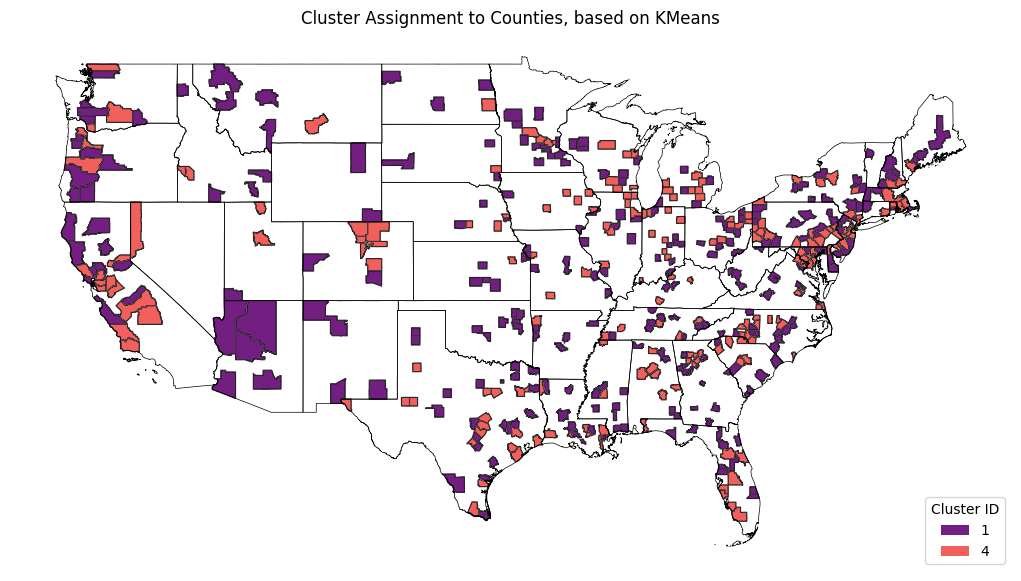

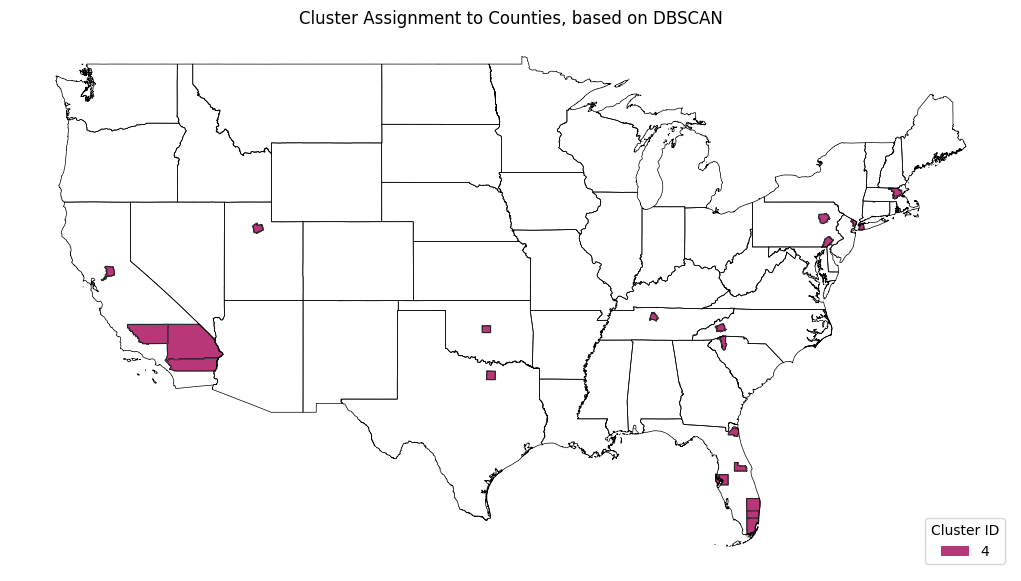

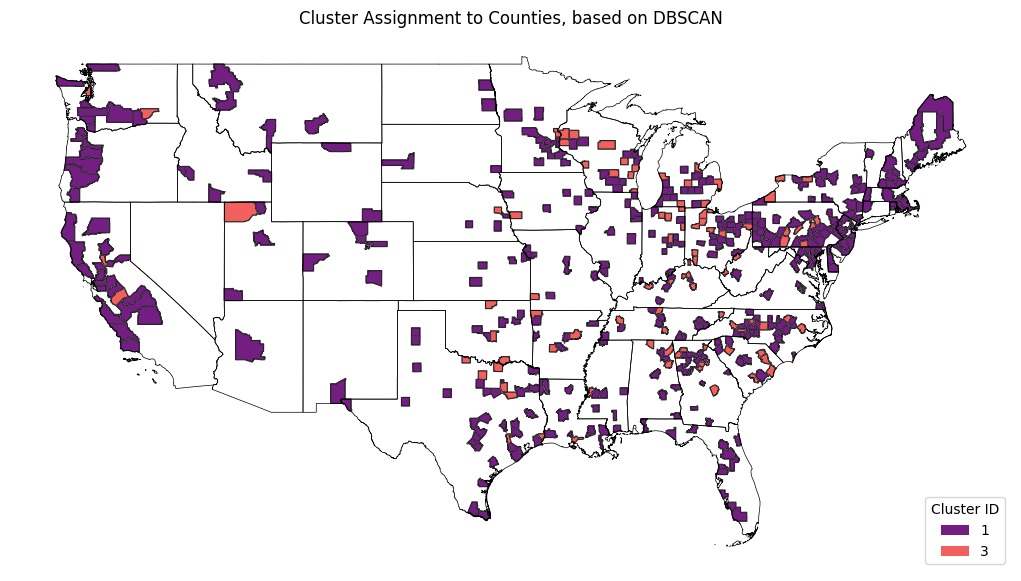

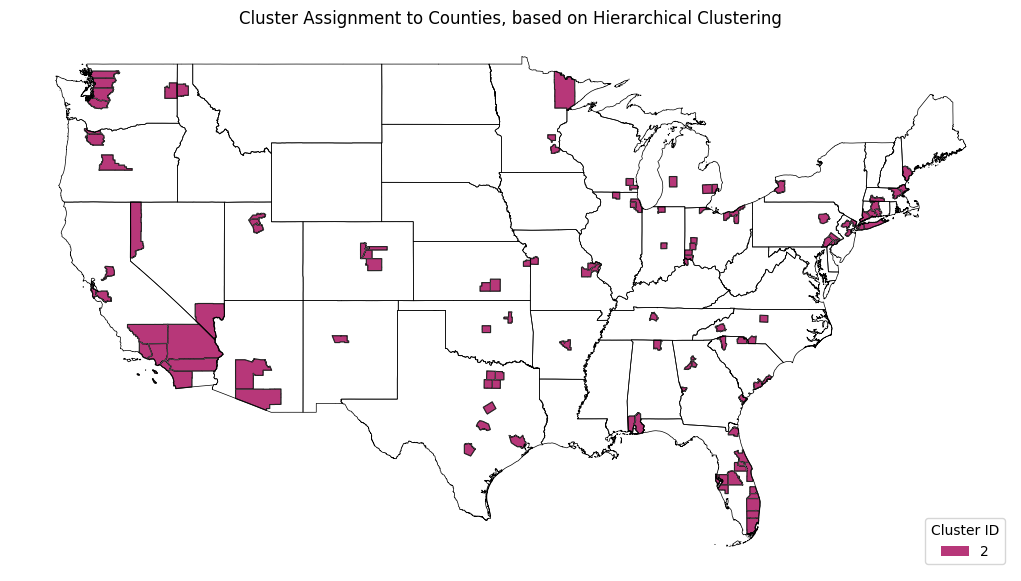

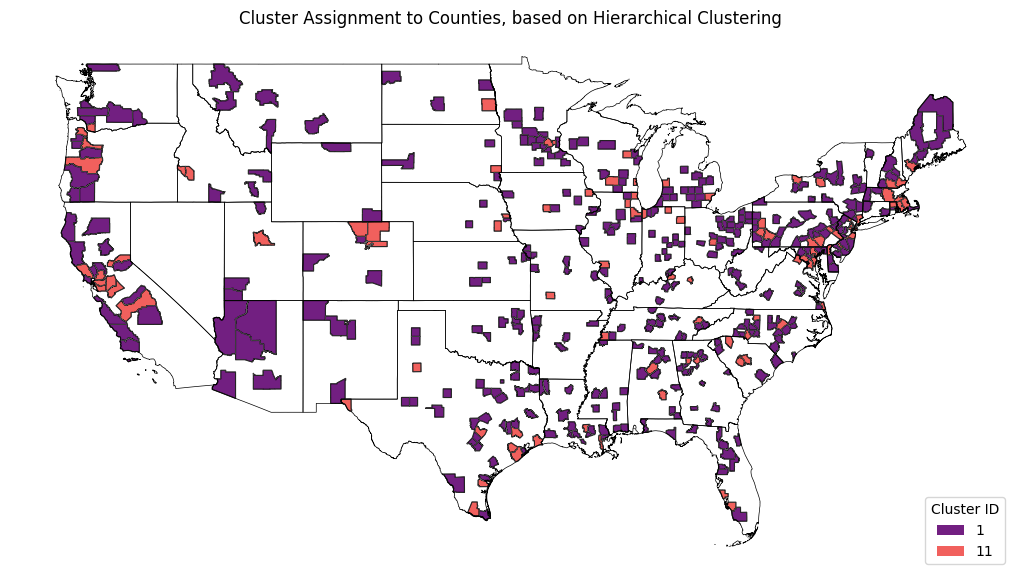

In [57]:
def vizualize_top_clusters(df, amount, name, calc = "mean"):
    best_clusters = get_best_cluster(df, amount, calc)
    best_cluster = best_clusters.head(1).index
    
    visualize_clusters_on_map(df, best_cluster, name)

    if amount > 1:
        other_good_clusters = best_clusters.head(amount).index
        other_good_clusters = other_good_clusters[1:]
        visualize_clusters_on_map(df, other_good_clusters, name)

vizualize_top_clusters(df_kmeans, 3, "KMeans")
vizualize_top_clusters(df_dbs, 3, "DBSCAN")
vizualize_top_clusters(df_hc, 3, "Hierarchical Clustering")

In [49]:
# Compare best cluster of df_kmeans and df_hc
best_km_cluster = get_best_cluster(df_kmeans, 1, "mean").index[0]
best_km_cluster_data = df_kmeans[df_kmeans['Cluster'] == best_km_cluster]
display(best_km_cluster_data)


best_hc_cluster = get_best_cluster(df_hc, 1, "mean").index[0]
best_hc_cluster_data = df_hc[df_hc['Cluster'] == best_hc_cluster]
display(best_hc_cluster_data)

# Percentage of intersection of both best clusters
intersection = best_km_cluster_data[best_km_cluster_data.index.isin(best_hc_cluster_data.index)]
percentage = len(intersection) / len(best_km_cluster_data) * 100
print(f"{percentage:.2f}% of the best cluster of KMeans is in the best cluster of HC")


,49-3023,49-9041,49-9071,51-4041,51-4121,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest,averageGdp,averageGdpGrowthPerYear,Cluster
FIPS,,,,,,,,,,,,,,
01089,0.664408,0.727876,0.713905,0.724550,0.705852,0.693195,0.574922,0.655156,0.688175,0.700534,0.755023,0.817775,0.195089,8
06037,1.000000,0.885593,0.980420,1.000000,0.917257,1.000000,0.966108,1.000000,0.967951,0.884160,0.993462,1.000000,0.185434,8
06081,0.737306,0.522131,0.708044,0.622011,0.586371,0.773824,0.505132,0.850918,0.403381,0.597664,0.813900,0.927996,0.187846,8
06085,0.803247,0.739085,0.837185,0.874684,0.769017,0.831077,0.839773,0.869471,0.753160,0.762990,0.892573,0.987177,0.204823,8
09009,0.752948,0.650098,0.710647,0.796644,0.609168,0.764357,0.693743,0.707659,0.506666,0.647599,0.811480,0.848730,0.183164,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27003,0.679411,0.623487,0.685607,0.860694,0.739580,0.719075,0.679269,0.647447,0.334040,0.601038,0.808018,0.820340,0.181877,8
48201,0.964292,1.000000,1.000000,0.950720,1.000000,0.948864,1.000000,0.971773,0.590108,1.000000,1.000000,0.980956,0.185315,8
26081,0.770810,0.793974,0.821227,0.873477,0.755401,0.796311,0.726847,0.802249,0.507310,0.460831,0.882888,0.870287,0.188439,8


,49-3023,49-9041,49-9071,51-4041,51-4121,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest,averageGdp,averageGdpGrowthPerYear,Cluster
FIPS,,,,,,,,,,,,,,
01089,0.664408,0.727876,0.713905,0.724550,0.705852,0.693195,0.574922,0.655156,0.688175,0.700534,0.755023,0.817775,0.195089,2
06037,1.000000,0.885593,0.980420,1.000000,0.917257,1.000000,0.966108,1.000000,0.967951,0.884160,0.993462,1.000000,0.185434,2
06081,0.737306,0.522131,0.708044,0.622011,0.586371,0.773824,0.505132,0.850918,0.403381,0.597664,0.813900,0.927996,0.187846,2
06085,0.803247,0.739085,0.837185,0.874684,0.769017,0.831077,0.839773,0.869471,0.753160,0.762990,0.892573,0.987177,0.204823,2
09009,0.752948,0.650098,0.710647,0.796644,0.609168,0.764357,0.693743,0.707659,0.506666,0.647599,0.811480,0.848730,0.183164,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27003,0.679411,0.623487,0.685607,0.860694,0.739580,0.719075,0.679269,0.647447,0.334040,0.601038,0.808018,0.820340,0.181877,2
48201,0.964292,1.000000,1.000000,0.950720,1.000000,0.948864,1.000000,0.971773,0.590108,1.000000,1.000000,0.980956,0.185315,2
26081,0.770810,0.793974,0.821227,0.873477,0.755401,0.796311,0.726847,0.802249,0.507310,0.460831,0.882888,0.870287,0.188439,2


98.04% of the best cluster of KMeans is in the best cluster of HC


### Outlier Analysis
Doing an outlier analysis in our case is pretty interesting as the cluster seem to have a clear heirachy, meaning that the best cluster is the best in every feature. Therefore we expect the outleirs to maybe be more distinct FIPS which are good in some features only and are a expert FIPS.

In [50]:
outlier = df_dbs[df_dbs['Cluster'] == '-1']
outlier = outlier.drop(columns=['Cluster'])
dbs_mean = df_dbs.groupby('Cluster').mean()
dbs_std = df_dbs.groupby('Cluster').mean()
dbs_mean_of_std = df_dbs.groupby('Cluster').std().mean()


In [51]:
dbs_std

,49-3023,49-9041,49-9071,51-4041,51-4121,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest,averageGdp,averageGdpGrowthPerYear
Cluster,,,,,,,,,,,,,
-1,0.344096,0.286696,0.303973,0.245778,0.290373,0.417395,0.149772,0.290857,0.037922,0.145505,0.488546,0.640745,0.202765
0,0.192520,0.043979,0.032316,0.005283,0.017085,0.303136,0.000794,0.033425,0.000000,0.003815,0.304257,0.584248,0.203894
1,0.582023,0.514857,0.573183,0.529404,0.543234,0.626435,0.540109,0.586831,0.000295,0.568361,0.690297,0.764103,0.190870
2,0.000000,0.010751,0.005695,0.000000,0.000992,0.000000,0.000000,0.003492,0.000000,0.000000,0.084460,0.522113,0.203539
3,0.476004,0.457440,0.488854,0.487888,0.514606,0.534456,0.545584,0.474039,0.000000,0.003043,0.622667,0.724422,0.191676
4,0.779517,0.673916,0.764301,0.685894,0.687428,0.791688,0.726918,0.792599,0.516442,0.785373,0.830984,0.856507,0.187975
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


49-3023                    0.658370
49-9041                    0.617250
49-9071                    0.682257
51-4041                    0.668517
51-4121                    0.652748
emp_8111                   0.689383
emp_3320A2                 0.584785
emp_2362                   0.679495
emp_3364                   0.343777
emp_2373                   0.594393
emp_rest                   0.763515
averageGdp                 0.803593
averageGdpGrowthPerYear    0.190940
dtype: float64

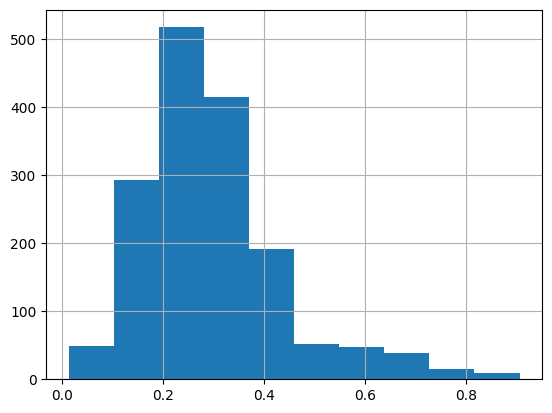

In [52]:
meanv_valeus_of_fips = outlier.mean(axis=1)
meanv_valeus_of_fips.hist()
top_10_percent_outlier = outlier[meanv_valeus_of_fips > meanv_valeus_of_fips.quantile(0.9)]
top_10_percent_outlier.mean()


In [53]:
import pandas as pd

# Assuming df_dbs and top_20_percent_outlier are predefined DataFrames
# Replace this with the actual DataFrame structure in your context

# Group by Cluster and calculate the mean
cluster_mean_df = df_dbs.groupby('Cluster').mean()

# Calculate the mean for top_20_percent_outlier and set a custom index
best_outliers_mean = top_10_percent_outlier.mean().to_frame().T
best_outliers_mean.index = ['best_outliers']  # Name the row

# Concatenate the new row for mean analysis
cluster_mean_df = pd.concat([cluster_mean_df, best_outliers_mean])

# Rank the clusters by mean
cluster_mean_rank = cluster_mean_df.rank(ascending=False)

# Calculate the overall average rank for mean
cluster_mean_rank["overall_avg"] = cluster_mean_rank.mean(axis=1).round(2)

# Sort by the overall average rank for mean
cluster_mean_rank = cluster_mean_rank.sort_values("overall_avg")

# Group by Cluster and calculate the standard deviation
cluster_std_df = df_dbs.groupby('Cluster').std()

# Calculate the standard deviation for top_20_percent_outlier and set a custom index
best_outliers_std = top_10_percent_outlier.std().to_frame().T
best_outliers_std.index = ['best_outliers']  # Name the row

# Concatenate the new row for standard deviation analysis
cluster_std_df = pd.concat([cluster_std_df, best_outliers_std])

# Rank the clusters by standard deviation
cluster_std_rank = cluster_std_df.rank(ascending=True)

# Calculate the overall average rank for standard deviation
cluster_std_rank["overall_avg"] = cluster_std_rank.mean(axis=1).round(2)

# Sort by the overall average rank for standard deviation
cluster_std_rank = cluster_std_rank.sort_values("overall_avg")



In [54]:
cluster_mean_rank
# The top 10 percent of the outliers are the second best "cluster"

,49-3023,49-9041,49-9071,51-4041,51-4121,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest,averageGdp,averageGdpGrowthPerYear,overall_avg
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.46
best_outliers,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,2.23
1,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,6.0,3.38
3,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,6.5,6.0,4.0,4.0,4.0,4.27
-1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,5.0,3.0,4.62
0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.5,5.0,6.0,6.0,1.0,5.58
2,7.5,7.0,7.0,7.5,7.0,7.5,7.5,7.0,6.5,7.5,7.0,7.0,2.0,6.77
5,7.5,8.0,8.0,7.5,8.0,7.5,7.5,8.0,6.5,7.5,8.0,8.0,8.0,7.69


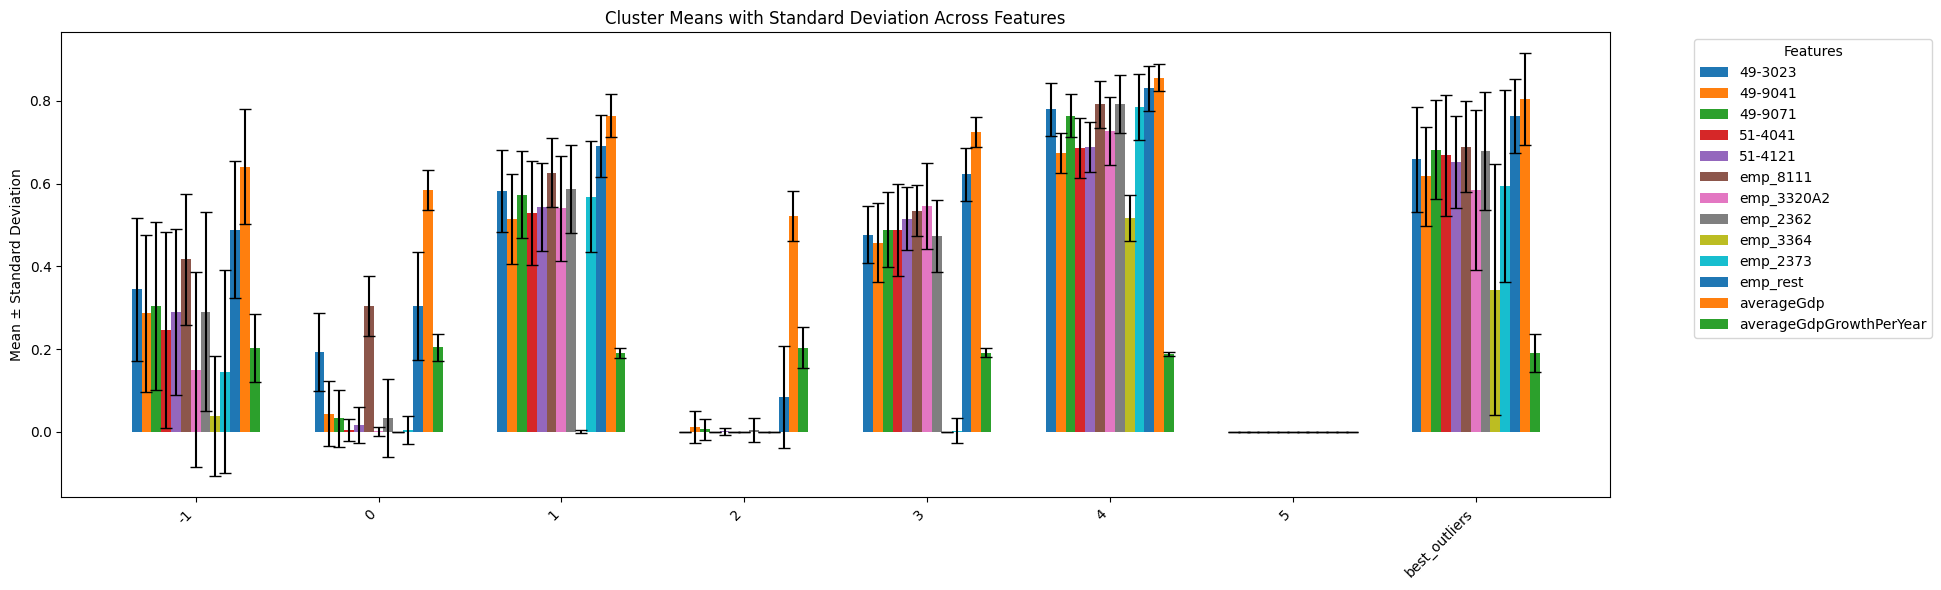

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Define clusters and features
clusters = cluster_mean_df.index
features = cluster_mean_df.columns

# Calculate means and standard deviations
means = cluster_mean_df.values
stds = cluster_std_df.values

# Grouped bar plot parameters
x = np.arange(len(clusters))  # Cluster indices
width = 0.7 / len(features)  # Dynamic bar width to fit 10 features

# Set up the figure size dynamically based on the number of features
fig, ax = plt.subplots(figsize=(max(10, len(features) * 1.5), 6))

# Plot each feature as a grouped bar with error bars
for i, feature in enumerate(features):
    ax.bar(x + i * width, means[:, i], width, yerr=stds[:, i],
           capsize=4, label=feature)

# Add labels, ticks, and legend
ax.set_xticks(x + (width * len(features) / 2) - width / 2)
ax.set_xticklabels(clusters, rotation=45, ha="right")
ax.set_ylabel("Mean ± Standard Deviation")
ax.set_title("Cluster Means with Standard Deviation Across Features")
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


This plot visualizes this relationship really well. Even though the Cluster 4 (best one) and the best outliers are very similar of the mean the stnadrd deviation for them is signifcantly higher, especially for emp_3364

,49-3023,49-9041,49-9071,51-4041,51-4121,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest,averageGdp,averageGdpGrowthPerYear,overall_avg
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.46
best_outliers,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,2.23
1,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,6.0,3.38
3,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,6.5,6.0,4.0,4.0,4.0,4.27
-1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,5.0,3.0,4.62
0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.5,5.0,6.0,6.0,1.0,5.58
2,7.5,7.0,7.0,7.5,7.0,7.5,7.5,7.0,6.5,7.5,7.0,7.0,2.0,6.77
5,7.5,8.0,8.0,7.5,8.0,7.5,7.5,8.0,6.5,7.5,8.0,8.0,8.0,7.69


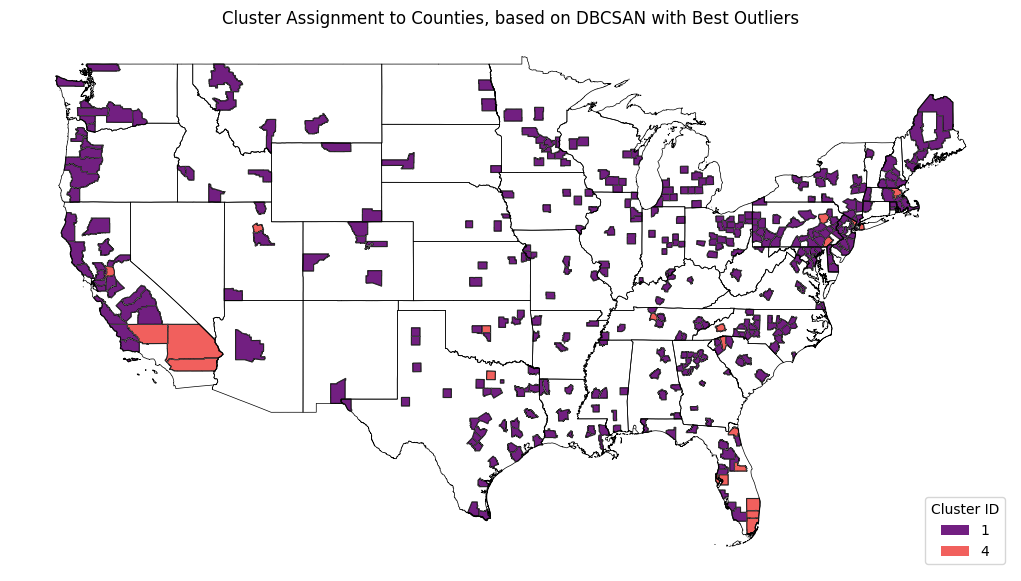

In [56]:
len(top_10_percent_outlier)
cluster_df_rank = cluster_mean_df.rank(ascending=False)

# Sort the cluster_df_rank by the mean value over all columns
cluster_df_rank["overall_avg"] = cluster_df_rank.mean(axis=1).round(2)
cluster_df_rank = cluster_df_rank.sort_values("overall_avg")
display(cluster_df_rank)

top_clusters = cluster_df_rank.head(3).index

visualize_clusters_on_map(df_dbs, top_clusters, 'DBCSAN with Best Outliers')